In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import CIFAR10
from tqdm import tqdm

### Save Data as Arrays

In [2]:
root="/mnt/ssd/ronak/datasets/cifar10"
download = True
train_data = CIFAR10(root, download=download)
test_data = CIFAR10(root, train=False, download=download)

x_train = train_data.data
x_test = test_data.data
y_train = np.array(train_data.targets)
y_test = np.array(test_data.targets)

100%|██████████| 170498071/170498071 [00:03<00:00, 45787827.19it/s]


Extracting /mnt/ssd/ronak/datasets/cifar10/cifar-10-python.tar.gz to /mnt/ssd/ronak/datasets/cifar10
Files already downloaded and verified


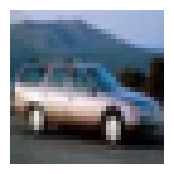

In [3]:
# check images
image = x_train[4]

# plt.axis("off")
fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(image)
plt.show()

In [4]:
save_dir = "/mnt/ssd/ronak/datasets/cifar10"

np.save(os.path.join(save_dir, "x_train"), x_train)
np.save(os.path.join(save_dir, "y_train"), y_train)
np.save(os.path.join(save_dir, "x_test"),  x_test)
np.save(os.path.join(save_dir, "y_test"),  y_test)

### Create Random Quantization

In [5]:
from sklearn.cluster import KMeans

In [6]:
root = "/mnt/ssd/ronak/datasets/cifar10"

x_train = np.load(os.path.join(root, "x_train.npy"))
y_train = np.load(os.path.join(root, "y_train.npy"))
x_test  = np.load(os.path.join(root, "x_test.npy"))
y_test  = np.load(os.path.join(root, "y_test.npy"))

In [7]:
def quantize(n_bins=8):
    # for labels, they are already quantized
    suffix = f"_quantized_{n_bins}.npy"
    np.save(os.path.join(root, "y_train" + suffix), y_train)
    np.save(os.path.join(root, "y_test" + suffix), y_test)

    kmeans = KMeans(n_clusters=n_bins, random_state=0, n_init="auto").fit(x_train.reshape(len(x_train), -1))

    cx_train = kmeans.predict(x_train.reshape(len(x_train), -1))
    cx_test  = kmeans.predict(x_test.reshape(len(x_test), -1))

    np.save(os.path.join(root, "x_train" + suffix), cx_train)
    np.save(os.path.join(root, "x_test" + suffix), cx_test)

In [12]:
for b in tqdm([53, 54, 55]):
    quantize(n_bins=b)

100%|██████████| 3/3 [01:35<00:00, 31.90s/it]


In [13]:
def simulate_probably(objects, k, b, s=1000):
    np.random.seed(123)
    count = 0
    for _ in range(s):
        batch = np.random.choice(objects, size=(b,), replace=False)
        count += int(len(np.unique(batch)) == k)
    return count / s

In [18]:
batch_size = 512

ks = np.array([8, 16, 32, 40, 48, 52, 53, 54, 55, 56, 60])
probs = []
for k in ks:
    objects = np.load(os.path.join(root, f"x_train_quantized_{k}.npy"))
    probs.append(simulate_probably(objects, k, batch_size))
    print(f"{k}: {probs[-1]:0.4f}")


8: 1.0000
16: 1.0000
32: 1.0000
40: 0.9950
48: 0.9840
52: 0.9600
53: 0.9470
54: 0.9450
55: 0.0040
56: 0.0040
60: 0.0040


Text(0.5, 1.0, 'Probablity of All Clusters Observed')

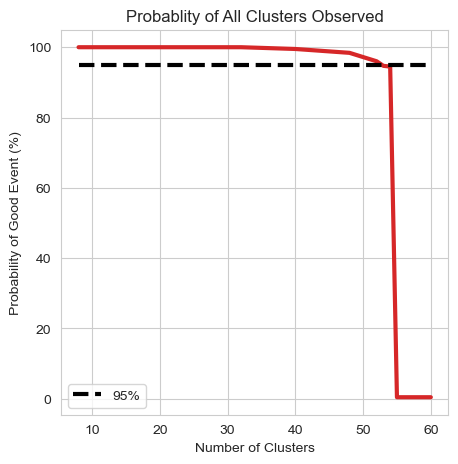

In [24]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(5,5))

probs = np.array(probs)
ax.plot(ks, 100 * probs, linewidth=3, color="tab:red")
ax.hlines(y=95, xmin=ks.min(), xmax=ks.max(), color="black", linestyle="--", linewidth=3, label="95%")

ax.legend(loc="lower left")

ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Probability of Good Event (%)")
ax.set_title("Probablity of All Clusters Observed")

In [2]:
root = "/mnt/ssd/ronak/datasets/cifar10"
# for n_bins in [8, 16, 32, 40, 48, 64]:

n_bins = 40

cx_train = np.load(os.path.join(root, f"x_train_quantized_{n_bins}.npy"))
cy_train = np.load(os.path.join(root, f"y_train_quantized_{n_bins}.npy"))

ind, count = np.unique(cx_train, return_counts=True)
px = count / len(cx_train)

ind, count = np.unique(cy_train, return_counts=True)
py = count / len(cy_train)

In [3]:
np.save(os.path.join(root, "x_marginal.npy"), px)
np.save(os.path.join(root, "y_marginal.npy"), py)